In [1]:
from dataclasses import dataclass
from itertools import accumulate

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Zestaw 4

In [2]:
@dataclass(order=True)
class Event:
    time: float
    users: int
        
@dataclass
class Parameters:
    lambdaA: float
    lambdaS: float
    N: int
    lambda_string: str = ""

In [3]:
def generate_events(parameters, with_raw_data=False):
    
    arrival_times = np.add.accumulate(np.random.exponential(1 / parameters.lambdaA, parameters.N))
    service_times = np.random.exponential(1 / parameters.lambdaS, parameters.N)
    
    leave_times = np.zeros(parameters.N)
    leave_times[0] = arrival_times[0] + service_times[0]
    
    for i in range(1, N):
        if leave_times[i-1] < arrival_times[i]:
            leave_times[i] = arrival_times[i] + service_times[i]
        else:
            leave_times[i] = leave_times[i-1] + service_times[i]
    
    raw_times = (arrival_times, leave_times)
            
    arrival_events = list(map(lambda time: Event(time, 1), arrival_times))
    leave_events = list(map(lambda time: Event(time, -1), leave_times))
    all_events = arrival_events + leave_events

    all_events.sort()
    index_of_last_incoming = next(i for i, ev in enumerate(reversed(all_events)) if ev.users == 1)
    all_events = all_events[:-index_of_last_incoming]
        
    events = list(accumulate(
        all_events, 
        lambda acc, ev: Event(ev.time, acc.users + ev.users), 
        initial=(Event(0, 0))
    ))
                  
    if with_raw_data:
        return (events, raw_times)
    
    return events

## Zadanie 1

In [4]:
N = 40
P = [
    Parameters(1/20, 1/15, N, "1/15"),
    Parameters(1/20, 1/20, N, "1/20"),
    Parameters(1/20, 1/25, N, "1/25"),
]

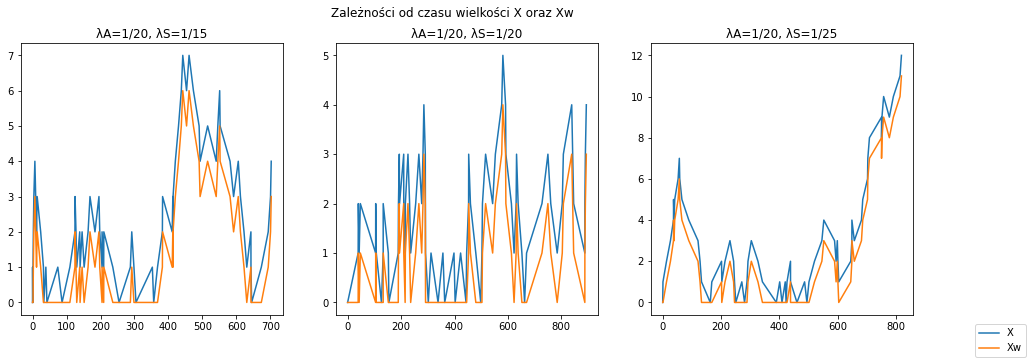

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

for p, ax in zip(P, axes):
    events_with_user_count = generate_events(p)
    
    t = [ev.time for ev in events_with_user_count]
    X = [ev.users for ev in events_with_user_count]
    Xw = [max(x - 1, 0) for x in X]
    
    ax.set_title(f"λA=1/20, λS={p.lambda_string}")
    ax.plot(t, X, label="X")
    ax.plot(t, Xw, label="Xw")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
fig.suptitle("Zależności od czasu wielkości X oraz Xw")

plt.savefig("zadanie1.png", facecolor='white')
plt.show()

## Zadanie 2

In [6]:
REPETITIONS = 50
N = 40
lambdaA = 1/20
lambdaA_string = "1/20"

P = [
    Parameters(lambdaA, 1/35, N, "1/35"),
    Parameters(lambdaA, 1/30, N, "1/30"),
    Parameters(lambdaA, 1/25, N, "1/25"),
    Parameters(lambdaA, 1/20, N, "1/20"),
    Parameters(lambdaA, 1/15, N, "1/15"),
    Parameters(lambdaA, 1/10, N, "1/10"),
    Parameters(lambdaA, 1, N, "1"),
    Parameters(lambdaA, 2, N, "2"),
]

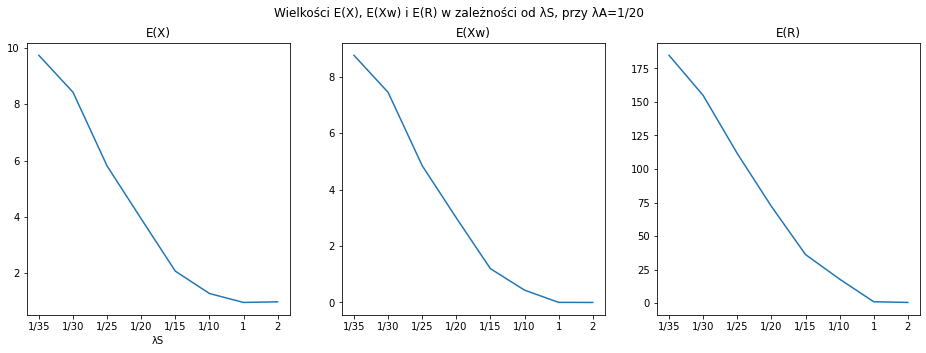

In [7]:
init_keys = [p.lambda_string for p in P]
EX = dict.fromkeys(init_keys, 0)
EXw = dict.fromkeys(init_keys, 0)
ER = dict.fromkeys(init_keys, 0) 

for _ in range(REPETITIONS):
    for p in P:
        events, (arrival_times, leave_times) = generate_events(p, with_raw_data=True)
        
        suma = 0
        wagi = 0
        for next_ev, prev_ev in zip(events[1:], events[:-1]):
            suma += next_ev.users * (next_ev.time - prev_ev.time)
            wagi += next_ev.time - prev_ev.time
        EX[p.lambda_string] += suma / wagi
        
        events_in_queue = list(map(lambda ev: Event(ev.time, max(0, ev.users-1)), events))
        suma = 0
        wagi = 0
        for next_ev, prev_ev in zip(events_in_queue[1:], events_in_queue[:-1]):
            suma += next_ev.users * (next_ev.time - prev_ev.time)
            wagi += next_ev.time - prev_ev.time
        EXw[p.lambda_string] += suma / wagi
    
        # do ostatniego zdarzenia-przyjścia
        max_idx = np.argwhere(leave_times < arrival_times[-1])[-1][-1]
        ER[p.lambda_string] += (leave_times[:max_idx] - arrival_times[:max_idx]).mean()

for key in init_keys:
    EX[key] /= REPETITIONS
    EXw[key] /= REPETITIONS
    ER[key] /= REPETITIONS
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

axes[0].set_title(f"E(X)")
axes[0].plot(EX.keys(), EX.values())
axes[0].set_xlabel("λS")

axes[1].set_title(f"E(Xw)")
axes[1].plot(EXw.keys(), EXw.values())
axes[0].set_xlabel("λS")

axes[2].set_title(f"E(R)")
axes[2].plot(ER.keys(), ER.values())
axes[0].set_xlabel("λS")

fig.suptitle(f"Wielkości E(X), E(Xw) i E(R) w zależności od λS, przy λA={lambdaA_string}")

plt.savefig("zadanie2.png", facecolor='white')
plt.show()

## Zadanie 3

In [8]:
N = 100
lambdaS = 1/20

D = [18, 19, 20, 21]
P = [Parameters(1/d, lambdaS, N, f"1/{d}") for d in D]
P = [
    Parameters(1/18, lambdaS, N, "1/18"),
    Parameters(1/18, lambdaS, N, "1/19"),
    Parameters(1/18, lambdaS, N, "1/20"),
    Parameters(1/18, lambdaS, N, "1/21"),
]

In [9]:
print(f"|  λA  |   E(X)   | λA * E(R) | ")
print("|------|----------|-----------|")

for p in P:
    events, (arrival_times, leave_times) = generate_events(p, with_raw_data=True)
    
    suma = 0
    wagi = 0
    for next_ev, prev_ev in zip(events[1:], events[:-1]):
        suma += next_ev.users * (next_ev.time - prev_ev.time)
        wagi += next_ev.time - prev_ev.time
    EX = suma / wagi

    # do ostatniego zdarzenia-przyjścia
    max_idx = np.argwhere(leave_times < arrival_times[-1])[-1][-1]
    ER = (leave_times[:max_idx] - arrival_times[:max_idx]).mean()
    
    print(f"|{p.lambda_string:^6}|{EX:9.5f} |{p.lambdaA * ER:10.5f} |")


|  λA  |   E(X)   | λA * E(R) | 
|------|----------|-----------|
| 1/18 | 12.71480 |  12.16543 |
| 1/19 |  3.65949 |   3.31459 |
| 1/20 | 17.95385 |  14.86932 |
| 1/21 | 21.88418 |  21.92466 |
